In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




id='1-VAkSMbyBflB8M4XshTx-UooTG2KQEXI'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data')

id='1tIZDxN-UuzPMeu6vJS4UPSQZyN2D5Ji4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('articles1.csv')



In [ ]:
!pip install pyLDAvis
!pip install hlda

     |████████████████████████████████| 1.6MB 3.4MB/s 
     |████████████████████████████████| 552kB 39.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=844cb0ddbbad1a870b487ac41bcb8f2eeb57ecbffb80483389013497daade1f3
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=e6842d44dc549d311438c01a9ddf992188a04402dd5bf097371b21fb51734658
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
  Created wheel for hlda: filename=hlda-0.2-cp36-none-any.whl size=5034 sha256=5fd33fa5db35ee1e192e3ff375ccdcf58907457f7e86c465c136794ec6e0c2dd
  Stored in directory: /root/.cache/pip/wheels/c0/96/0d/79c6a4e965efa74c4541cc833dda92244d5477e4831a5f0f7e
Successfully built hlda


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import nltk; nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
other = ["wa","ha","one","two","id","re","http","com","mr","image","photo","caption","don","sen","pic","co",
             "source","watch","play","duration","video","momentjs","getty","images","newsletter", "story", "go", "like", "say",
             "will", "just", "today", "can", "year", "make", "view", "read",'tell',"also","thing","things","would"]
stop_words.extend(letters)
stop_words.extend(other)

LookupError: ignored

In [ ]:
df = pd.read_csv('articles1.csv',sep=',', error_bad_lines=False,encoding="latin-1")
df.head

<bound method NDFrame.head of        Unnamed: 0  ...                                            content
0               0  ...  WASHINGTON  â   Congressional Republicans ha...
1               1  ...  After the bullet shells get counted, the blood...
2               2  ...  When Walt Disneyâs âBambiâ opened in 194...
3               3  ...  Death may be the great equalizer, but it isnâ...
4               4  ...  SEOUL, South Korea  â   North Koreaâs lead...
...           ...  ...                                                ...
49995       53287  ...  As chairman and CEO of ExxonMobil, Rex Tillers...
49996       53288  ...  Iâve spent nearly 20 years looking at intell...
49997       53289  ...    Donald Trump will not be taking necessary st...
49998       53290  ...  Dozens of   colleges could be forced to close ...
49999       53291  ...  The force of gravity can be described using a ...

[50000 rows x 10 columns]>

In [ ]:
data = df.content.values.tolist()


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)).encode('utf-8') for sent in data]



data = [re.sub('\\\\x[a-z0-9][a-z0-9][a-z0-9]?', ' ', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent)) for sent in data]


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
def remove_stopwords(texts):
    #letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
    #other = ["wa","ha","one","two","id","re","http","com","mr","image","photo","caption","don","sen","pic","co",
    #         "source","watch","play","duration","video","momentjs","getty","images","newsletter", "story", "go", "like", "say",
     #        "will", "just", "today", "can", "year", "make", "view", "read",'tell',"also","thing","things","would"]
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
data_words_nostops = remove_stopwords(data_words)


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words_nostops], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_bigrams(texts, bigram_model = bigram_mod):
    return [bigram_model[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)



In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])



In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print (data_lemmatized.index("say"))
print(data_lemmatized[:1])

KeyboardInterrupt: ignored

In [ ]:
data_lemmatized = remove_stopwords(data_lemmatized)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)


In [ ]:

# Create Corpus
texts = data_lemmatized
#print (texts.index("say"))



In [ ]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

NameError: ignored

In [ ]:
n_samples = 500       # no of iterations for the sampler
alpha = 10.0          # smoothing over level distributions
gamma = 1.0           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1             # smoothing over topic-word distributions
num_levels = 3        # the number of levels in the tree
display_topics = 50   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights


In [ ]:
hlda = HierarchicalLDA(new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.095284 -0.011813       1        1  20.639471
3     -0.147184 -0.091212       2        1  13.637485
6     -0.118058  0.065820       3        1   8.433470
9     -0.186683  0.022755       4        1   7.872113
0     -0.085199  0.152931       5        1   6.285422
5     -0.050445 -0.197330       6        1   6.083776
1     -0.012562  0.101087       7        1   5.966290
8      0.070749  0.238430       8        1   4.849555
10    -0.127683 -0.096497       9        1   4.841796
12     0.105654  0.108333      10        1   4.233064
13    -0.031528  0.064399      11        1   3.942308
7      0.215702  0.072795      12        1   3.836792
11     0.034584 -0.229280      13        1   3.485566
4      0.202244 -0.028464      14        1   3.095530
14     0.225691 -0.171953      15        1   2.797368, topic_info=          Term          Freq         Total Category  logprob  loglift
213      trump  99939.000000  99939.000000  Default  30.0000  30.0000
697     police  27880.000000  27880.000000  Default  29.0000  29.0000
503        get  44619.000000  44619.000000  Default  28.0000  28.0000
318   campaign  28795.000000  28795.000000  Default  27.0000  27.0000
64    election  26803.000000  26803.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
62      effect   1408.621460   5192.503906  Topic15  -5.3891   2.2719
44       could   2001.990967  43338.535156  Topic15  -5.0375   0.5016
257       area   1529.143188   9605.469727  Topic15  -5.3070   1.7389
2366    likely   1464.419067  16090.263672  Topic15  -5.3502   1.1797
766     result   1424.822266  13669.683594  Topic15  -5.3776   1.3154

[1008 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
4225       2  0.948038    abroad
4225       6  0.051380    abroad
57246      9  0.997990       aca
5149       2  0.042706  academic
5149      14  0.956424  academic
...      ...       ...       ...
952        8  0.034100     young
952       10  0.132402     young
952       11  0.017487     young
952       12  0.259308     young
952       14  0.410197     young

[2514 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 7, 10, 1, 6, 2, 9, 11, 13, 14, 8, 12, 5, 15])

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.188545468103372

Coherence Score:  0.49953136037178714


In [ ]:
new_doc = pd.read_csv('data',sep=',', error_bad_lines=False,encoding="latin-1")
new_doc=new_doc.drop('Unnamed: 0',axis=1).dropna()
new_doc.head()

,articles
0,If you want to do business with Miller Industr...
1,Remarks of Senator Barack Obama: Apostolic Chu...
2,One out of every four Pennsylvania households ...
5,"On Sept. 28, pastors from 20 states will give ..."
7,WASHINGTON â The Republican National Committ...


In [ ]:
data = new_doc.articles.values.tolist()


# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)).encode('utf-8') for sent in data]

data = [re.sub('\\\\x[a-z0-9][a-z0-9][a-z0-9]?', ' ', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

# Remove new line characters
data = [str(sent).replace('\\n', '') for sent in data]

# Remove new line characters
data = [str(sent).replace('\\r', '') for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent)) for sent in data]


In [ ]:
#corpus_sent = []
politifcat_topics = []
for item in data:
  sentence= (item[1:])
  #print (sentence)
  data_words_sent= gensim.utils.simple_preprocess(str(sentence), deacc=True)
  data_words_sent = [data_words_sent]
  #print(data_words_sent)
  #data_words = list(sent_to_words(sentence))
  bigram_sent = gensim.models.Phrases(data_words_sent, min_count=5, threshold=100) # higher threshold fewer phrases.
  #trigram_sent = gensim.models.Phrases(bigram_sent[data_words_sent], threshold=100)  

  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod_sent = gensim.models.phrases.Phraser(bigram_sent)
  #trigram_mod_sent = gensim.models.phrases.Phraser(trigram_sent)


  data_words_nostops_sent = remove_stopwords(data_words_sent)
  data_words_bigrams_sent = make_bigrams(data_words_nostops_sent, bigram_mod_sent)
  #print(data_words_bigrams_sent)
  data_lemmatized_sent = lemmatization(data_words_bigrams_sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
  data_lemmatized_sent = remove_stopwords(data_lemmatized_sent)
  #print(data_lemmatized_sent)
  id2word_sent = corpora.Dictionary(data_lemmatized_sent)
  corpus_sent = [id2word_sent.doc2bow(data_sent) for data_sent in data_lemmatized_sent]
  #print(corpus_sent)
  #corpus_sent = [x for x in corpus_sent if x != []]
  #print (corpus_sent)
  #print(len(data))
  #print(len(corpus_sent))
  topics_in_sent=lda_model.get_document_topics(corpus_sent, minimum_probability=0.0)
  for i in topics_in_sent:
    politifcat_topics.append(i)
  


print(politifcat_topics[0:5])

[[(0, 0.027613217), (1, 0.01185253), (2, 0.0775089), (3, 0.22223113), (4, 0.009776218), (5, 0.13586031), (6, 0.051159397), (7, 0.010176933), (8, 0.00829137), (9, 0.017209258), (10, 0.36853182), (11, 0.018053083), (12, 0.014414558), (13, 0.017587181), (14, 0.009734128)], [(0, 0.000984703), (1, 0.027145809), (2, 0.16181268), (3, 0.12720488), (4, 0.0068054977), (5, 0.07299956), (6, 0.1632737), (7, 0.029740011), (8, 0.09145819), (9, 0.08171136), (10, 0.14440721), (11, 0.010639769), (12, 0.028612964), (13, 0.038134705), (14, 0.015068966)], [(0, 0.0037007004), (1, 0.00091400376), (2, 0.17258602), (3, 0.3053093), (4, 0.0007442294), (5, 0.10996673), (6, 0.15706716), (7, 0.0007667159), (8, 0.0006210461), (9, 0.08243912), (10, 0.14651883), (11, 0.0014586333), (12, 0.0011016323), (13, 0.011643985), (14, 0.005161873)], [(0, 0.007259889), (1, 0.014769054), (2, 0.23448777), (3, 0.22516991), (4, 0.011205437), (5, 0.100089096), (6, 0.17493872), (7, 0.0003353871), (8, 0.020766094), (9, 0.076842435), (1

In [ ]:
#corpus_sent = []
politifcat_topics = []
for item in data:
  sentence= (item[1:])
  #print (sentence)
  data_words_sent= gensim.utils.simple_preprocess(str(sentence), deacc=True)
  data_words_sent = [data_words_sent]
  #print(data_words_sent)
  #data_words = list(sent_to_words(sentence))
  bigram_sent = gensim.models.Phrases(data_words_sent, min_count=5, threshold=100) # higher threshold fewer phrases.
  #trigram_sent = gensim.models.Phrases(bigram_sent[data_words_sent], threshold=100)  

  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod_sent = gensim.models.phrases.Phraser(bigram_sent)
  #trigram_mod_sent = gensim.models.phrases.Phraser(trigram_sent)


  data_words_nostops_sent = remove_stopwords(data_words_sent)
  data_words_bigrams_sent = make_bigrams(data_words_nostops_sent, bigram_mod_sent)
  #print(data_words_bigrams_sent)
  data_lemmatized_sent = lemmatization(data_words_bigrams_sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
  data_lemmatized_sent = remove_stopwords(data_lemmatized_sent)
  #print(data_lemmatized_sent)
  id2word_sent = corpora.Dictionary(data_lemmatized_sent)
  corpus_sent = [id2word_sent.doc2bow(data_sent) for data_sent in data_lemmatized_sent]
  #print(corpus_sent)
  #corpus_sent = [x for x in corpus_sent if x != []]
  #print (corpus_sent)
  #print(len(data))
  #print(len(corpus_sent))
  topics_in_sent=lda_model.get_document_topics(corpus_sent, minimum_probability=0.0)
  for i in topics_in_sent:
    politifcat_topics.append(i)
  


print(politifcat_topics[0:5])

[[(0, 0.027613217), (1, 0.01185253), (2, 0.0775089), (3, 0.22223113), (4, 0.009776218), (5, 0.13586031), (6, 0.051159397), (7, 0.010176933), (8, 0.00829137), (9, 0.017209258), (10, 0.36853182), (11, 0.018053083), (12, 0.014414558), (13, 0.017587181), (14, 0.009734128)], [(0, 0.000984703), (1, 0.027145809), (2, 0.16181268), (3, 0.12720488), (4, 0.0068054977), (5, 0.07299956), (6, 0.1632737), (7, 0.029740011), (8, 0.09145819), (9, 0.08171136), (10, 0.14440721), (11, 0.010639769), (12, 0.028612964), (13, 0.038134705), (14, 0.015068966)], [(0, 0.0037007004), (1, 0.00091400376), (2, 0.17258602), (3, 0.3053093), (4, 0.0007442294), (5, 0.10996673), (6, 0.15706716), (7, 0.0007667159), (8, 0.0006210461), (9, 0.08243912), (10, 0.14651883), (11, 0.0014586333), (12, 0.0011016323), (13, 0.011643985), (14, 0.005161873)], [(0, 0.007259889), (1, 0.014769054), (2, 0.23448777), (3, 0.22516991), (4, 0.011205437), (5, 0.100089096), (6, 0.17493872), (7, 0.0003353871), (8, 0.020766094), (9, 0.076842435), (1

In [ ]:
df_results=pd.DataFrame(politifcat_topics)
df_results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"(0, 0.027613217)","(1, 0.01185253)","(2, 0.0775089)","(3, 0.22223113)","(4, 0.009776218)","(5, 0.13586031)","(6, 0.051159397)","(7, 0.010176933)","(8, 0.00829137)","(9, 0.017209258)","(10, 0.36853182)","(11, 0.018053083)","(12, 0.014414558)","(13, 0.017587181)","(14, 0.009734128)"
1,"(0, 0.000984703)","(1, 0.027145809)","(2, 0.16181268)","(3, 0.12720488)","(4, 0.0068054977)","(5, 0.07299956)","(6, 0.1632737)","(7, 0.029740011)","(8, 0.09145819)","(9, 0.08171136)","(10, 0.14440721)","(11, 0.010639769)","(12, 0.028612964)","(13, 0.038134705)","(14, 0.015068966)"
2,"(0, 0.0037007004)","(1, 0.00091400376)","(2, 0.17258602)","(3, 0.3053093)","(4, 0.0007442294)","(5, 0.10996673)","(6, 0.15706716)","(7, 0.0007667159)","(8, 0.0006210461)","(9, 0.08243912)","(10, 0.14651883)","(11, 0.0014586333)","(12, 0.0011016323)","(13, 0.011643985)","(14, 0.005161873)"
3,"(0, 0.007259889)","(1, 0.014769054)","(2, 0.23448777)","(3, 0.22516991)","(4, 0.011205437)","(5, 0.100089096)","(6, 0.17493872)","(7, 0.0003353871)","(8, 0.020766094)","(9, 0.076842435)","(10, 0.11379289)","(11, 0.0006470935)","(12, 0.0051759933)","(13, 0.009593547)","(14, 0.0049267067)"
4,"(0, 0.004215217)","(1, 0.0013480566)","(2, 0.08453845)","(3, 0.23479567)","(4, 0.0010930428)","(5, 0.09551544)","(6, 0.22719178)","(7, 0.001119256)","(8, 0.0009031383)","(9, 0.0850029)","(10, 0.2508286)","(11, 0.0023858382)","(12, 0.0015985632)","(13, 0.008387642)","(14, 0.0010764357)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,"(0, 0.02850999)","(1, 0.007419747)","(2, 0.10694885)","(3, 0.3452818)","(4, 0.0063960995)","(5, 0.09113204)","(6, 0.12156611)","(7, 0.0063826363)","(8, 0.005143652)","(9, 0.061202377)","(10, 0.1816446)","(11, 0.01092008)","(12, 0.009273398)","(13, 0.012041835)","(14, 0.0061367853)"
511,"(0, 0.007925106)","(1, 0.0035354565)","(2, 0.040676747)","(3, 0.42012948)","(4, 0.0029544334)","(5, 0.04075278)","(6, 0.028411437)","(7, 0.0030314596)","(8, 0.002452446)","(9, 0.11218217)","(10, 0.31911767)","(11, 0.0050562765)","(12, 0.0044822916)","(13, 0.006396683)","(14, 0.0028955843)"
512,"(0, 0.0046158438)","(1, 0.000627137)","(2, 0.10154503)","(3, 0.26486188)","(4, 0.005422226)","(5, 0.15934601)","(6, 0.19354498)","(7, 0.00049286924)","(8, 0.041001607)","(9, 0.09473014)","(10, 0.08789903)","(11, 0.0011577789)","(12, 0.011193228)","(13, 0.02317377)","(14, 0.010388462)"
513,"(0, 0.0031548839)","(1, 0.0008969789)","(2, 0.097894765)","(3, 0.2639748)","(4, 0.00072790676)","(5, 0.15187764)","(6, 0.19616805)","(7, 0.0007477485)","(8, 0.00060777186)","(9, 0.12137569)","(10, 0.14597237)","(11, 0.0014197442)","(12, 0.0010600608)","(13, 0.0071886643)","(14, 0.0069329035)"


In [ ]:
df_results_2=df_results
for ind, rows in df_results.iterrows():
  #print (rows)
  for indj,j in rows:
    #print (df_results_2[indj][ind])
    df_results_2[indj][ind]=j

NameError: ignored

In [ ]:
import pandas as pd
df_results_2=pd.read_csv('res.csv')
df_results_2=df_results_2.drop(["Unnamed: 0",'cluster'],axis=1)
df_results_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.027613,0.011853,0.077509,0.222231,0.009776,0.135860,0.051159,0.010177,0.008291,0.017209,0.368532,0.018053,0.014415,0.017587,0.009734
1,0.000985,0.027146,0.161813,0.127205,0.006805,0.073000,0.163274,0.029740,0.091458,0.081711,0.144407,0.010640,0.028613,0.038135,0.015069
2,0.003701,0.000914,0.172586,0.305309,0.000744,0.109967,0.157067,0.000767,0.000621,0.082439,0.146519,0.001459,0.001102,0.011644,0.005162
3,0.007260,0.014769,0.234488,0.225170,0.011205,0.100089,0.174939,0.000335,0.020766,0.076842,0.113793,0.000647,0.005176,0.009594,0.004927
4,0.004215,0.001348,0.084538,0.234796,0.001093,0.095515,0.227192,0.001119,0.000903,0.085003,0.250829,0.002386,0.001599,0.008388,0.001076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0.028510,0.007420,0.106949,0.345282,0.006396,0.091132,0.121566,0.006383,0.005144,0.061202,0.181645,0.010920,0.009273,0.012042,0.006137
511,0.007925,0.003535,0.040677,0.420129,0.002954,0.040753,0.028411,0.003031,0.002452,0.112182,0.319118,0.005056,0.004482,0.006397,0.002896
512,0.004616,0.000627,0.101545,0.264862,0.005422,0.159346,0.193545,0.000493,0.041002,0.094730,0.087899,0.001158,0.011193,0.023174,0.010388
513,0.003155,0.000897,0.097895,0.263975,0.000728,0.151878,0.196168,0.000748,0.000608,0.121376,0.145972,0.001420,0.001060,0.007189,0.006933


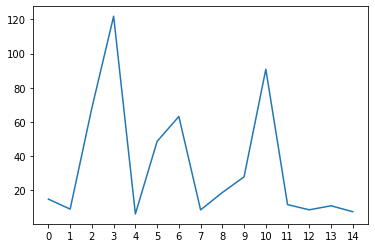

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_results_2.sum())

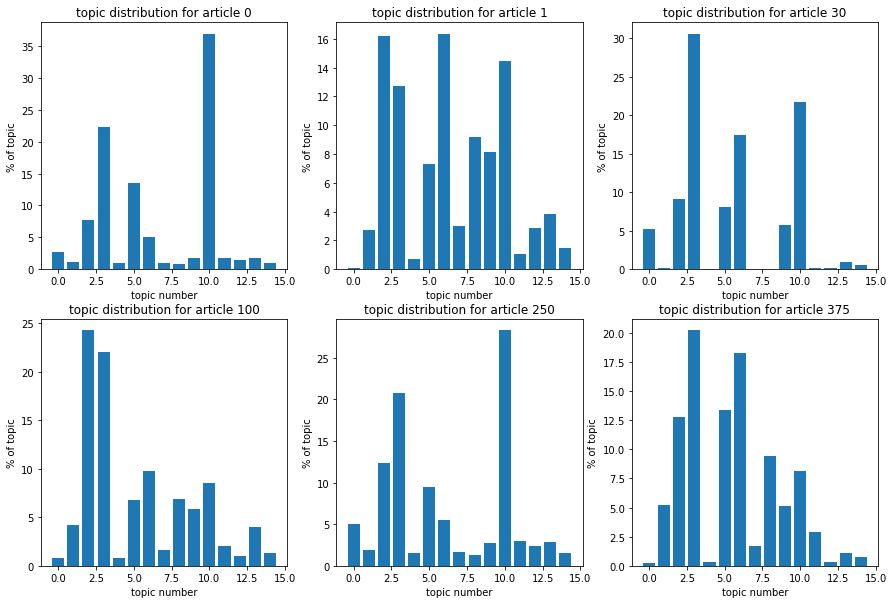

In [ ]:
nums=[0,1,30,100,250,375]
fig=plt.figure(figsize=(15, 10))
cnt=0
for i in nums:
  cnt+=1
  fig.add_subplot(2, 3, cnt)  
  plt.bar(range(15),df_results_2.loc[i]*100)
  plt.xlabel("topic number")
  plt.ylabel("% of topic")
  plt.title("topic distribution for article "+str(i))

In [ ]:
print(df_results_2['0'])
for i in range(0,15):
  df_results_2[str(i)]=pd.to_numeric(df_results_2[str(i)])
top=df_results_2.apply(lambda x: x.argmax(), axis=1)

0      0.027613
1      0.000985
2      0.003701
3      0.007260
4      0.004215
         ...   
510    0.028510
511    0.007925
512    0.004616
513    0.003155
514    0.044835
Name: 0, Length: 515, dtype: float64


Text(0.5, 1.0, 'Distribution of counts of Documents over Topic Number')

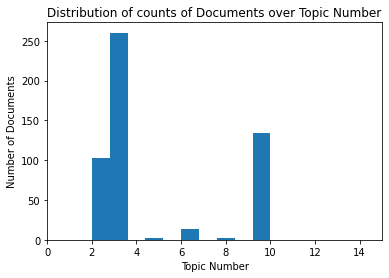

In [ ]:
plt.hist(top)
plt.xlim(0,15)
plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.title("Distribution of counts of Documents over Topic Number")

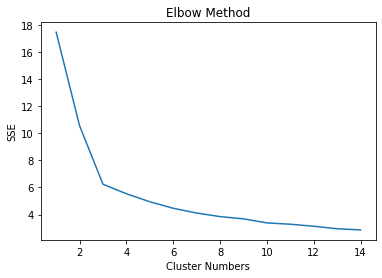

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
K = range(1,15)
SSE = []
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_results_2)
    SSE.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(K,SSE)
plt.title('Elbow Method')
plt.xlabel('Cluster Numbers')
plt.ylabel('SSE')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(df_results_2)

clusters = km.labels_.tolist()

CPU times: user 39 ms, sys: 0 ns, total: 39 ms
Wall time: 40.2 ms


In [ ]:
df_results_2['cluster']=clusters
df_results_2['cluster'].value_counts()

1    212
0    157
2    146
Name: cluster, dtype: int64

Text(0.5, 1.0, 'Numeber of News Articles in each cluster')

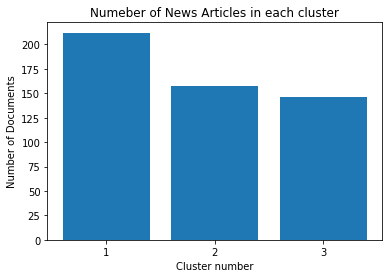

In [ ]:
plt.bar([1,2,3],df_results_2['cluster'].value_counts())
plt.xticks([1,2,3])
plt.xlabel("Cluster number")
plt.ylabel("Number of Documents")
plt.title('Numeber of News Articles in each cluster')